In [1]:
# ============================================================
# 0. Imports (same as before)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter
from scipy.optimize import minimize


# Ricker target + PQC definition helpers

In [2]:
# ============================================================
# 1. Ricker target state
# ============================================================
def ricker_target_state(n_sys, mu=0.5, Sigma=0.1):
    """
    Normalized Ricker (Mexican hat) wavelet over grid x in [0,1).
    """
    N = 2**n_sys
    x = np.arange(N) / N
    g = ((2 / (np.sqrt(3 * Sigma * np.pi))) ** 0.5) \
        * (1 - ((x - mu) / Sigma) ** 2) \
        * np.exp(-((x - mu) ** 2) / (2 * Sigma ** 2))
    g = g.astype(complex)
    g /= np.linalg.norm(g)
    return g


# ============================================================
# 2. Brickwall PQC (same structure as in the notebook)
# ============================================================

def U1_gate(a, b, c, label="U1"):
    sub = QuantumCircuit(1, name=label)
    sub.rz(a, 0)
    sub.ry(b, 0)
    sub.rz(c, 0)
    return sub.to_gate(label=label)

def entangling_block_gate(t7, t8, t9, label="Ent"):
    sub = QuantumCircuit(2, name=label)
    sub.cx(0, 1)        # first CNOT (q0→q1)
    sub.rz(t7, 0)       # Rz on control
    sub.ry(t8, 1)       # Ry on target
    sub.cx(1, 0)        # second CNOT (q1→q0)
    sub.ry(t9, 1)       # Ry on target again
    sub.cx(0, 1)        # third CNOT (q0→q1)
    return sub.to_gate(label=label)

def two_qubit_block_gate(thetas, label="U^(m)"):
    """
    thetas = [θ1 ... θ15] (15 Parameter objects)
    """
    sub = QuantumCircuit(2, name=label)
    # Pre-rotations
    sub.append(U1_gate(thetas[0], thetas[1], thetas[2],  label="U1_pre_q0"), [0])
    sub.append(U1_gate(thetas[3], thetas[4], thetas[5],  label="U1_pre_q1"), [1])
    # Entangling block
    sub.append(entangling_block_gate(thetas[6], thetas[7], thetas[8], label="Ent"), [0, 1])
    # Post-rotations
    sub.append(U1_gate(thetas[9],  thetas[10], thetas[11], label="U1_post_q0"), [0])
    sub.append(U1_gate(thetas[12], thetas[13], thetas[14], label="U1_post_q1"), [1])
    return sub.to_gate(label=label)

def brickwall_PQC(n_qubits=4, depth=3):
    """
    n_qubits = n_sys (system qubits only; no control here)
    depth    = number of brickwall layers
    """
    qc = QuantumCircuit(n_qubits)
    params = []
    param_index = 0

    for d in range(depth):
        # Alternate coupling pattern per layer: (0,1),(2,3)... then (1,2),(3,4)...
        pairs = [(i, i + 1) for i in range(d % 2, n_qubits - 1, 2)]
        for (q0, q1) in pairs:
            thetas = [Parameter(f"θ{param_index + i}") for i in range(15)]
            params += thetas
            param_index += 15
            block_label = f"U^{d}_({q0},{q1})"
            block_gate = two_qubit_block_gate(thetas, label=block_label)
            qc.append(block_gate, [q0, q1])

        qc.barrier()

    return qc, params


# Training + evaluation helper functions

In [3]:
# ============================================================
# 3. Parameter binding and cost / report utilities
# ============================================================

def bind_params(qc, params, theta_vec):
    """
    Bind a flat numpy array theta_vec onto the Parameter objects in params.
    """
    bind_map = {p: float(theta_vec[i]) for i, p in enumerate(params)}
    # assign_parameters works for recent Qiskit; if needed you can switch to bind_parameters
    return qc.assign_parameters(bind_map)

def psi_from_thetas(qc_template, params, theta_vec):
    qc = bind_params(qc_template, params, theta_vec)
    sv = Statevector.from_instruction(qc)
    return sv.data  # length 2^n_sys


def make_cost_fidelity(qc_template, params, g_vec):
    """
    C(θ) = 1 - |<g | ψ(θ)>|^2  (fidelity cost)
    """
    def cost(theta_vec):
        psi = psi_from_thetas(qc_template, params, theta_vec)
        overlap = np.vdot(g_vec, psi)
        return 1.0 - np.abs(overlap) ** 2
    return cost


def evaluate_solution(qc_template, params, theta_vec, g_vec):
    psi = psi_from_thetas(qc_template, params, theta_vec)
    overlap = np.vdot(g_vec, psi)
    fidelity = np.abs(overlap) ** 2
    max_diff = np.max(np.abs(g_vec - psi))
    return dict(
        psi=psi,
        fidelity=fidelity,
        max_diff=max_diff,
        overlap=overlap,
    )


def train_pqc_for_ricker(
    n_sys,
    depth,
    maxiter=3000,
    n_restarts=3,
    base_seed=7,
    vftol=1e-9,
    vgtol=1e-8,
    vmaxcor=20,
    veps=1e-8,
):
    """
    Train a brickwall PQC to approximate the Ricker wavelet for given n_sys & depth.
    
    Returns:
        result = {
            'n_sys', 'depth', 'maxiter',
            'best_theta', 'fidelity', 'max_diff',
            'psi', 'target', 'qc_trained',
            'overlap',
            'nit_per_restart', 'nit_total'
        }
    """
    N = 2**n_sys
    target = ricker_target_state(n_sys)

    # Build PQC on n_sys qubits (system only)
    qc_template, params = brickwall_PQC(n_qubits=n_sys, depth=depth)

    cost_fn = make_cost_fidelity(qc_template, params, target)

    best_res = None
    best_theta = None

    nit_per_restart = []
    nit_total = 0

    for r in range(n_restarts):
        seed = base_seed + r
        rng = np.random.default_rng(seed)
        theta0 = rng.uniform(0.0, 1.0, size=len(params))

        res = minimize(
            cost_fn,
            theta0,
            method="L-BFGS-B",
            options=dict(
                maxiter=maxiter,
                ftol=vftol,
                gtol=vgtol,
                maxcor=vmaxcor,
                eps=veps,
            ),
        )

        # Extract iteration count
        nit = getattr(res, "nit", None)
        nit_per_restart.append(nit)
        if nit is not None:
            nit_total += nit

        # Track best solution
        if best_res is None or res.fun < best_res.fun:
            best_res = res
            best_theta = res.x

    # Evaluate best solution
    eval_dict = evaluate_solution(qc_template, params, best_theta, target)
    qc_trained = bind_params(qc_template, params, best_theta)
    qc_trained.name = f"Trained_PQC_n{n_sys}_d{depth}"

    result = dict(
        n_sys=n_sys,
        depth=depth,
        maxiter=maxiter,
        best_theta=best_theta,
        psi=eval_dict["psi"],
        target=target,
        fidelity=eval_dict["fidelity"],
        max_diff=eval_dict["max_diff"],
        overlap=eval_dict["overlap"],
        qc_trained=qc_trained,
        nit_per_restart=nit_per_restart,
        nit_total=nit_total,
    )
    return result



# Test 1 – Fixed qubit count, vary PQC depth

[TEST 1] n_sys = 6
Minimum depth (rule) = 3
Testing depths = [3, 4, 5, 6]

[TEST 1] Training with depth=3
  Fidelity: 0.977648, max_diff: 0.156225

[TEST 1] Training with depth=4
  Fidelity: 0.996834, max_diff: 0.432755

[TEST 1] Training with depth=5
  Fidelity: 0.979686, max_diff: 0.584280

[TEST 1] Training with depth=6
  Fidelity: 0.997553, max_diff: 0.582954


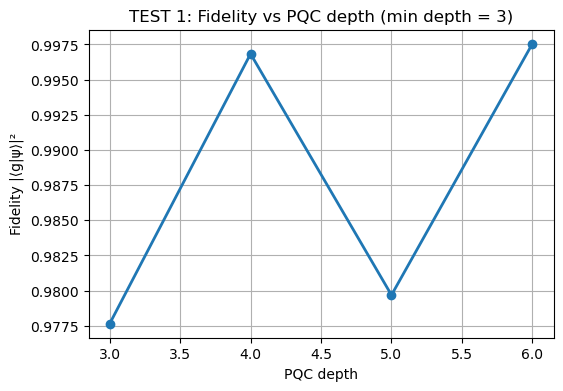

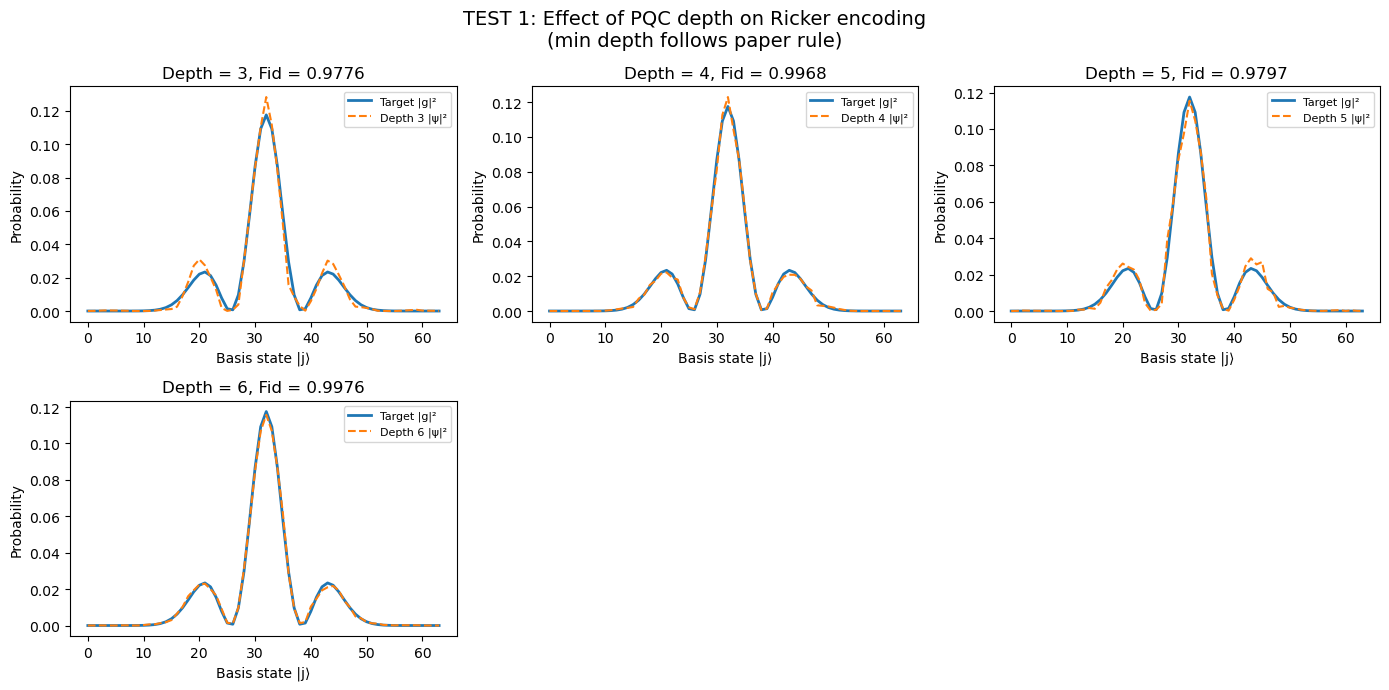

In [8]:
# ============================================================
# Depth rule (same as original notebook / paper)
# ============================================================
def depth_rule(n_sys):
    return int(np.floor(np.log2(n_sys + 1))) + 1


# ============================================================
# TEST 1 (updated):
# fixed n_sys, vary depth starting from depth_rule(n_sys)
# ============================================================

n_sys_fixed = 6  # same qubit count for test 1
depth_min = depth_rule(n_sys_fixed)
depth_list = [depth_min, depth_min+1, depth_min+2, depth_min+3]   # e.g., 3,4,5,6

maxiter_T1 = 1000
n_restarts_T1 = 1

results_T1 = []

print(f"[TEST 1] n_sys = {n_sys_fixed}")
print(f"Minimum depth (rule) = {depth_min}")
print(f"Testing depths = {depth_list}")

for depth in depth_list:
    print(f"\n[TEST 1] Training with depth={depth}")
    res = train_pqc_for_ricker(
        n_sys=n_sys_fixed,
        depth=depth,
        maxiter=maxiter_T1,
        n_restarts=n_restarts_T1,
        base_seed=10,
    )
    print(f"  Fidelity: {res['fidelity']:.6f}, max_diff: {res['max_diff']:.6f}")

    res["depth"] = depth
    results_T1.append(res)


# ============================================================
# Plot: Fidelity vs PQC depth
# ============================================================
plt.figure(figsize=(6,4))
plt.plot(
    [r["depth"] for r in results_T1],
    [r["fidelity"] for r in results_T1],
    marker="o",
    linewidth=2,
)
plt.xlabel("PQC depth")
plt.ylabel("Fidelity |⟨g|ψ⟩|²")
plt.title(f"TEST 1: Fidelity vs PQC depth (min depth = {depth_min})")
plt.grid(True)
plt.show()

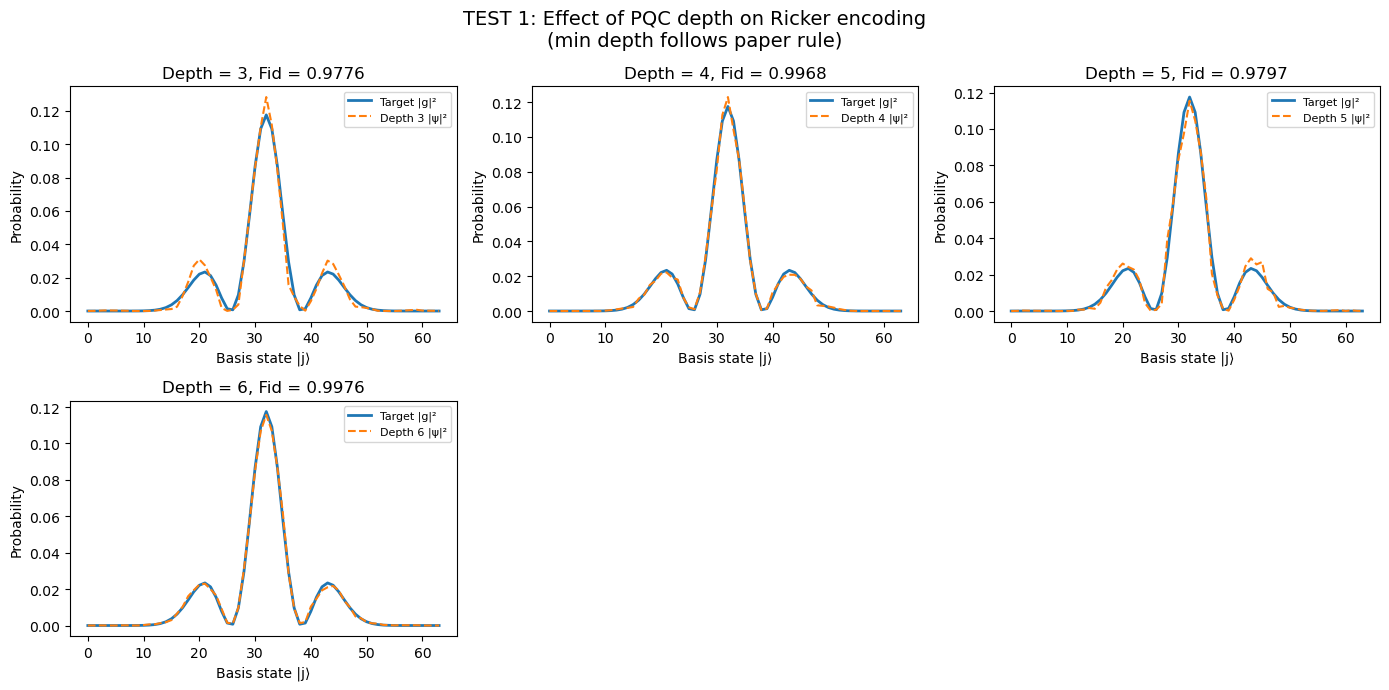

In [9]:

# ============================================================
# Plot: |ψ|² vs target for each depth
# ============================================================
fig, axes = plt.subplots(2, 3, figsize=(14, 7))
axes = axes.flatten()

x = np.arange(2**n_sys_fixed)
target = results_T1[0]["target"]

for i, res in enumerate(results_T1):
    ax = axes[i]
    ax.plot(x, np.abs(target)**2, label="Target |g|²", linewidth=2)
    ax.plot(x, np.abs(res["psi"])**2, "--", label=f"Depth {res['depth']} |ψ|²")
    ax.set_title(f"Depth = {res['depth']}, Fid = {res['fidelity']:.4f}")
    ax.set_xlabel("Basis state |j⟩")
    ax.set_ylabel("Probability")
    ax.legend(fontsize=8)

# Hide empty axes
for j in range(len(results_T1), len(axes)):
    axes[j].axis("off")

fig.suptitle("TEST 1: Effect of PQC depth on Ricker encoding\n(min depth follows paper rule)", fontsize=14)
plt.tight_layout()
plt.show()

# Test 2 – Fixed n_sys and depth, vary optimization iterations

In [4]:
# ============================================================
# TEST 2: fixed n_sys & depth, vary maxiter
# ============================================================

n_sys_T2 = 6
depth_T2 = 3                 # e.g. the original log-scaling depth
maxiter_list = [50, 100, 150, 200, 400]
n_restarts_T2 = 1

results_T2 = []

for maxiter in maxiter_list:
    print(f"\n[TEST 2] Training for n_sys={n_sys_T2}, depth={depth_T2}, maxiter={maxiter}")
    
    res = train_pqc_for_ricker(
        n_sys=n_sys_T2,
        depth=depth_T2,
        maxiter=maxiter,
        n_restarts=n_restarts_T2,
        base_seed=30,
        vftol=0.0,      # prevent early convergence
        vgtol=0.0      # prevent gradient-based stopping
    )
    
    print(f"  Fidelity: {res['fidelity']:.6f}, max_diff: {res['max_diff']:.6f}")
    
    # --------------------------------------------------------
    # NEW: show number of optimizer iterations
    # --------------------------------------------------------
    print(f"  Iterations used (nit_total): {res['nit_total']}")     # <<< ADDED >>>
    print(f"  nit_per_restart: {res['nit_per_restart']}")         # <<< ADDED >>>
    # --------------------------------------------------------

    results_T2.append(res)

# ---- Plot: Fidelity vs maxiter ----
plt.figure(figsize=(6,4))
plt.plot(
    [r["maxiter"] for r in results_T2],
    [r["fidelity"] for r in results_T2],
    marker="o",
)
plt.xlabel("L-BFGS-B maxiter")
plt.ylabel("Fidelity |⟨g|ψ⟩|²")
plt.xscale("log")
plt.title(f"TEST 2: Fidelity vs optimization iterations\n(n_sys={n_sys_T2}, depth={depth_T2})")
plt.grid(True, which="both", ls="--")
plt.show()



[TEST 2] Training for n_sys=6, depth=3, maxiter=50
  Fidelity: 0.943363, max_diff: 0.633945
  Iterations used (nit_total): 50
  nit_per_restart: [50]

[TEST 2] Training for n_sys=6, depth=3, maxiter=100
  Fidelity: 0.969077, max_diff: 0.644814
  Iterations used (nit_total): 100
  nit_per_restart: [100]

[TEST 2] Training for n_sys=6, depth=3, maxiter=150
  Fidelity: 0.978347, max_diff: 0.646317
  Iterations used (nit_total): 116
  nit_per_restart: [116]

[TEST 2] Training for n_sys=6, depth=3, maxiter=200
  Fidelity: 0.978347, max_diff: 0.646317
  Iterations used (nit_total): 116
  nit_per_restart: [116]

[TEST 2] Training for n_sys=6, depth=3, maxiter=400


KeyboardInterrupt: 

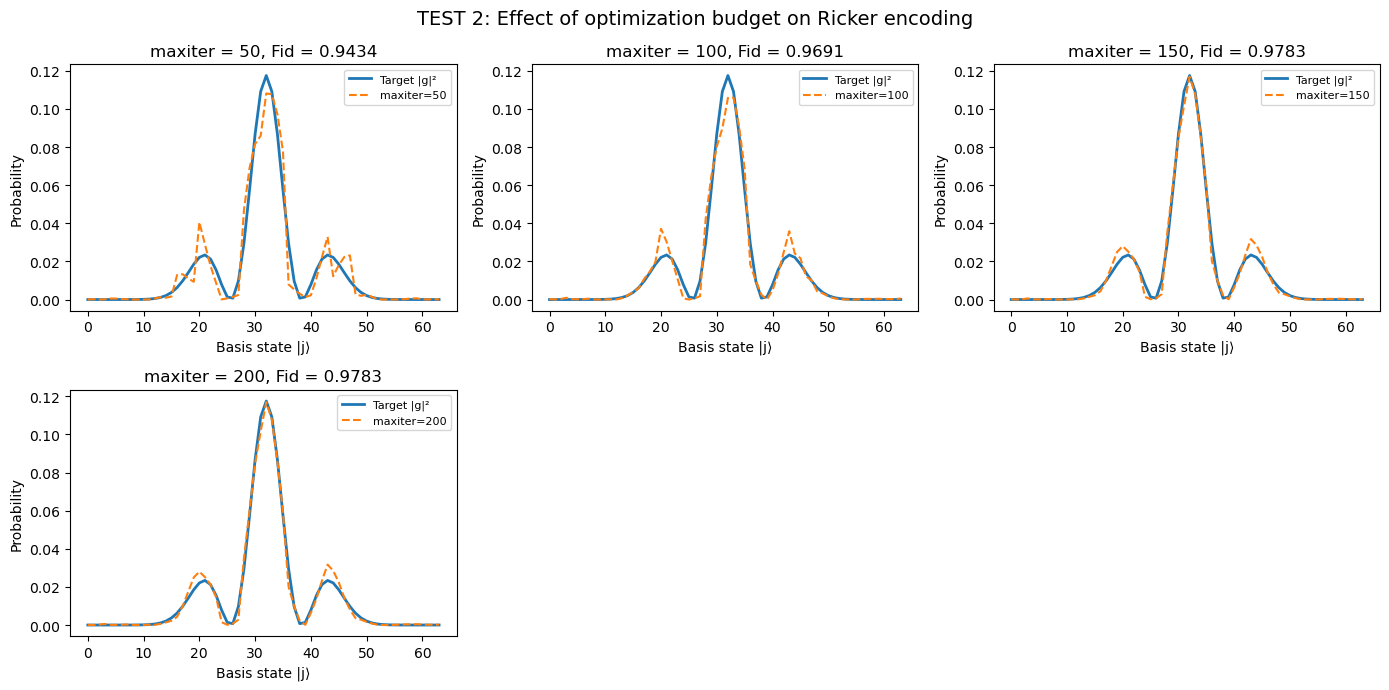

In [5]:

# ---- Plot: |ψ|² vs target for several maxiter values ----
fig, axes = plt.subplots(2, 3, figsize=(14, 7))
axes = axes.flatten()

x = np.arange(2**n_sys_T2)
target = results_T2[0]["target"]

for i, res in enumerate(results_T2):
    ax = axes[i]
    ax.plot(x, np.abs(target)**2, label="Target |g|²", linewidth=2)
    ax.plot(x, np.abs(res["psi"])**2, "--", label=f"maxiter={res['maxiter']}")
    ax.set_title(f"maxiter = {res['maxiter']}, Fid = {res['fidelity']:.4f}")
    ax.set_xlabel("Basis state |j⟩")
    ax.set_ylabel("Probability")
    ax.legend(fontsize=8)

for j in range(len(results_T2), len(axes)):
    axes[j].axis("off")

fig.suptitle("TEST 2: Effect of optimization budget on Ricker encoding", fontsize=14)
plt.tight_layout()
plt.show()


# Test 3 – Increase n_sys while keeping PQC depth and optimization fixed

In [5]:
# ============================================================
# Helper: depth rule from the original code / paper
# depth = floor(log2(n_sys + 1)) + 1
# ============================================================
def depth_rule(n_sys):
    return int(np.floor(np.log2(n_sys + 1))) + 1


# ============================================================
# TEST 3 (updated):
# vary n_sys, use depth_PQC = floor(log2(n_sys+1)) + 1
# keep optimization settings fixed
# ============================================================

n_sys_list_T3 = [4, 5, 6, 7]   # system sizes to test
maxiter_T3 = 1000              # same optimization budget for all
n_restarts_T3 = 1

results_T3 = []

for n_sys in n_sys_list_T3:
    depth_T3 = depth_rule(n_sys)
    print(f"\n[TEST 3] Training for n_sys={n_sys}, depth={depth_T3}, maxiter={maxiter_T3}")

    res = train_pqc_for_ricker(
        n_sys=n_sys,
        depth=depth_T3,
        maxiter=maxiter_T3,
        n_restarts=n_restarts_T3,
        base_seed=50,
    )

    print(f"  Fidelity: {res['fidelity']:.6f}, max_diff: {res['max_diff']:.6f}")
    res["depth"] = depth_T3   # tag depth explicitly for plotting
    results_T3.append(res)

# ---- Plot: Fidelity vs n_sys (with depth labels) ----
plt.figure(figsize=(6,4))
plt.plot(
    [r["n_sys"] for r in results_T3],
    [r["fidelity"] for r in results_T3],
    marker="o",
)
for r in results_T3:
    plt.text(
        r["n_sys"],
        r["fidelity"],
        f"d={r['depth']}",
        fontsize=8,
        ha="left",
        va="bottom",
    )
plt.xlabel("n_sys (number of system qubits)")
plt.ylabel("Fidelity |⟨g|ψ⟩|²")
plt.title("TEST 3: Fidelity vs system size\n(depth = floor(log2(n_sys+1))+1)")
plt.grid(True)
plt.show()

# ---- Plot: |ψ|² vs target for each n_sys ----
rows = 2
cols = int(np.ceil(len(results_T3) / rows))
fig, axes = plt.subplots(rows, cols, figsize=(14, 6))
axes = axes.flatten()

for i, res in enumerate(results_T3):
    n_sys = res["n_sys"]
    depth = res["depth"]
    N = 2**n_sys
    x = np.arange(N)
    target = res["target"]
    psi = res["psi"]

    ax = axes[i]
    ax.plot(x, np.abs(target)**2, label="Target |g|²", linewidth=2)
    ax.plot(x, np.abs(psi)**2, "--", label="PQC |ψ|²")
    ax.set_title(f"n_sys={n_sys}, depth={depth}, N={N}\nFid={res['fidelity']:.4f}")
    ax.set_xlabel("Basis state |j⟩")
    ax.set_ylabel("Probability")
    ax.legend(fontsize=8)

for j in range(len(results_T3), len(axes)):
    axes[j].axis("off")

fig.suptitle("TEST 3: Effect of grid size n_sys (with depth rule)", fontsize=14)
plt.tight_layout()
plt.show()


[TEST 3] Training for n_sys=4, depth=3, maxiter=1000


KeyboardInterrupt: 